# Converting model outputs to vector format using the Python API

To use segmentation masks in a geospatial application, one often needs to convert to a vector format. This is a non-trivial task in many cases and a lot of science goes into finding the best way to convert a pixel mask to vector-formatted outputs, but we've provided a basic implementation in `solaris` for users to build from.

Let's begin with an image showing some predicted building footprints:

In [1]:
import solaris as sol
import os
import skimage
import matplotlib.pyplot as plt

mask_image = skimage.io.imread(os.path.join(sol.data.data_dir, 'sample_fbc_from_df2px.tif'))

f, ax = plt.subplots(figsize=(10, 8))
plt.imshow(mask_image)

In [2]:
mask_image.shape

(900, 900, 3)

This image has the value 255 in the first channel anywhere a building footprint is predicted, 255 in the second channel where an edge is predicted, and 255 in the third channel anywhere two buildings are very near one another:

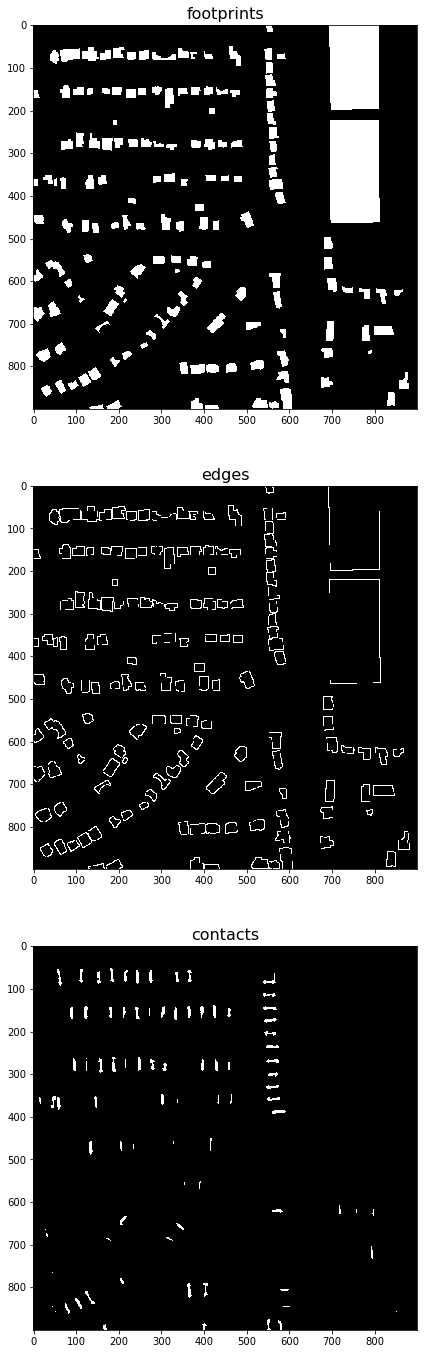

In [3]:
f, axarr = plt.subplots(3, 1, figsize=(8, 24))

axarr[0].imshow(mask_image[:, :, 0], cmap='gray')
axarr[0].set_title('footprints', fontsize=16)
axarr[1].imshow(mask_image[:, :, 1], cmap='gray')
axarr[1].set_title('edges', fontsize=16)
axarr[2].imshow(mask_image[:, :, 2], cmap='gray')
axarr[2].set_title('contacts', fontsize=16);

First, we'll work with just the first channel for the simplest case of going from footprints to polygons. We'll use the `solaris.vector.mask.mask_to_poly_geojson()` function. This function has a number of arguments for customizing function:

- pred_arr: The prediction array (in this case, `mask_image`)
- channel_scaling: Scaling factors to use if using a multi-channel mask; see the next example.
- reference_im: A georeferenced image that has the same extent as `mask_image` to use for georeferencing polygons. This is optional.
- output_path: The path to the file to save. If not provided, the geometries are returned in a geopandas `GeoDataFrame`, but no file is saved.
- output_type: Should the saved file be a `'csv'` or a `'geojson'`?
- min_area: Use this argument to set a minimum area for geometries to be retained. This can be useful to eliminate speckling or very small, erroneous predictions.
- bg_threshold: The value to set to separate background from foreground pixels in the mask. In this example, we'll use `1` because anything >0 is foreground.
- simplify: A boolean to indicate whether or not you'd like to use the Douglas-Peucker algorithm to simplify geometries. This can _dramatically_ accelerate processing of geometries later, and can also make your geometries look nicer!
- tolerance: The tolerance parameter for the Douglas-Peucker simplification algorithm. Only has an effect if `simplify=True`.

Let's convert the first channel of the above mask to georegistered polygons.

In [4]:
geoms = sol.vector.mask.mask_to_poly_geojson(mask_image[:, :, 0])
geoms.head()

,geometry,value
0,"POLYGON ((542 0, 542 1, 545 1, 545 2, 546 2, 5...",255.0
1,"POLYGON ((202 52, 202 53, 201 53, 190 53, 190 ...",255.0
2,"POLYGON ((339 54, 339 72, 340 72, 340 78, 352 ...",255.0
3,"POLYGON ((548 55, 548 56, 547 56, 542 56, 542 ...",255.0
4,"POLYGON ((261 59, 261 60, 260 60, 248 60, 248 ...",255.0


There's the output! We'll use a shapely convenience function to visualize them:

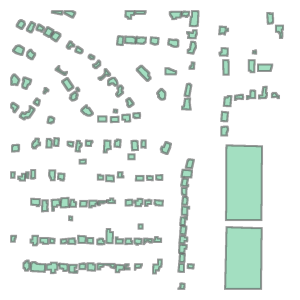

In [5]:
from shapely.ops import cascaded_union
cascaded_union(geoms['geometry'])

And there the geometries are! Just like the input mask (flipped vertically because they count up instead of down; if you georeference your outputs, this won't matter.)

What if we want to use some complicated logic around a multi-channel mask to generate predictions? For example, what if we want to predict where edges and contact points are, then subtract those values to make sure we separate buildings well (a common challenge for building footprint extraction algorithms!) To do so, we'll use the `channel_scaling` argument, which allows you to specify the following operation:

$$mask(x, y) = \sum_{c}^{ } mask[x, y, c]\times channel\_scaling[c]$$

Where c is the channel index. So, in this example, let's say we want to subtract the edges and contact layers from the footprint - we will set `channel_scaling=[1, -1, -1]`:

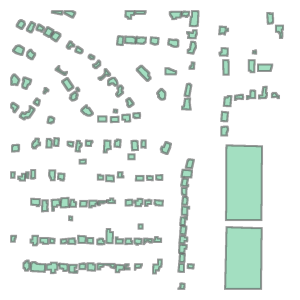

In [6]:
geoms = sol.vector.mask.mask_to_poly_geojson(mask_image, channel_scaling=[1, -1, -1])
cascaded_union(geoms['geometry'])

Though not readily apparent in this particular example, this can be extremely useful with imperfect predictions.